<a href="https://colab.research.google.com/github/rgolds5/DS-Unit-2-Tree-Ensembles/blob/master/DS_Sprint_Challenge_7_Classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date'])
assert df.shape == (13958, 20)

This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.

In [2]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


In [0]:
train = df[df['game_date'] < '2017-10-01']
val = df[(df['game_date'] >= '2017-10-01') & (df['game_date'] < '2018-10-01')]
test = df[df['game_date'] >= '2018-10-01']

assert train.shape == (11081, 20)
assert val.shape == (1168, 20)
assert test.shape == (1709, 20)

In [0]:
import pandas as pd

def wrangle(X):
    X = X.copy()
    X['game_year'] = X['game_date'].dt.year
    X['game_month'] = X['game_date'].dt.month
    X['game_day'] = X['game_date'].dt.day
    X = X.drop(columns = 'game_date')
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

target = 'shot_made_flag'
train_features = train.drop(columns = target)
features = train_features.columns.tolist()

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [5]:
baseline = 1 - y_train.mean()
print(f'Baseline: {baseline:.3f}')

Baseline: 0.527


In [6]:
import numpy as np
from sklearn.metrics import accuracy_score
y_pred = np.zeros(len(y_val))
print(f'Validation Baseline Accuracy: {accuracy_score(y_val, y_pred):3f}')

Validation Baseline Accuracy: 0.516267


In [8]:
!pip install category_encoders

     |████████████████████████████████| 92kB 5.0MB/s 


In [0]:
import category_encoders as ce

OrdinalEncoder = ce.OrdinalEncoder
OneHotEncoder = ce.OneHotEncoder

In [0]:
from sklearn_pandas import DataFrameMapper, gen_features

ordinal_encode = gen_features(
    columns = [['action_type'], ['htm'], ['vtm']],
    classes = [OrdinalEncoder]
)
no_encode = gen_features(
    columns = [['game_year'], ['game_month'], ['game_day'], ['game_id'], ['game_event_id'],
              ['period'], ['minutes_remaining'], ['seconds_remaining'], ['shot_distance'],
              ['loc_x'], ['loc_y'], ['scoremargin_before_shot']],
    classes = None
)

mapped_features = (ordinal_encode + no_encode)
mapper = DataFrameMapper(mapped_features, df_out = True)

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    mapper,
    RandomForestClassifier(n_estimators = 100,
                          n_jobs = -1,
                          random_state = 42)
)

pipeline.fit(X_train, y_train)
print(f'Validation Score: {pipeline.score(X_val, y_val):.3f}')

Validation Score: 0.589


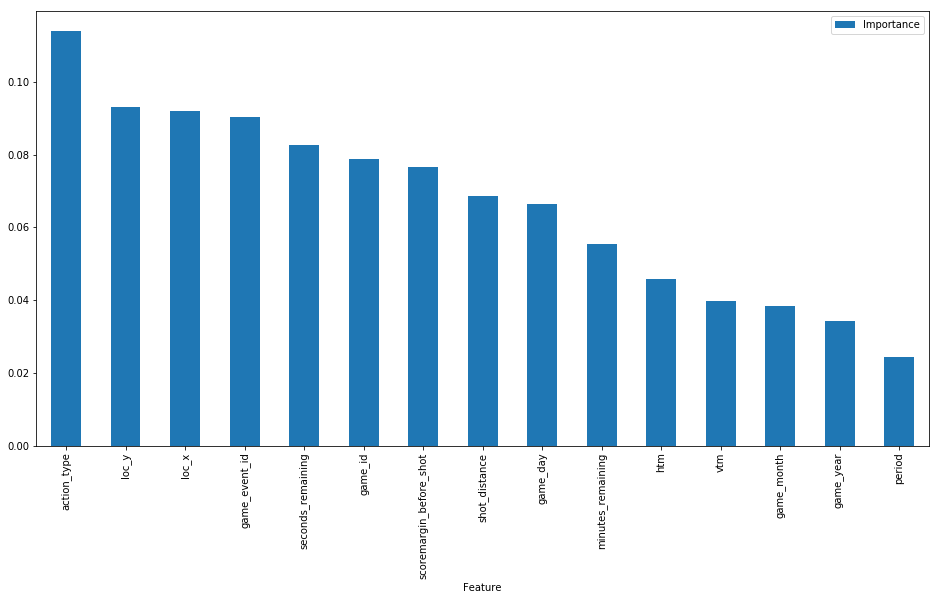

In [13]:
feature_importances = np.array(pipeline.named_steps['randomforestclassifier'].feature_importances_)
feature_names = np.array(pipeline.named_steps['dataframemapper'].transformed_names_)

importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importances_df.sort_values(by = 'Importance', ascending = False).plot.bar(x = 'Feature', y = 'Importance', figsize = (16, 8));

In [0]:
def create_features(X):
    X = X.copy()
    X['home_court_advantage'] = np.where(X['htm'] == 'GSW', 1, 0)
    X['opponent'] = np.where(X['home_court_advantage'] == 1, X['vtm'], X['htm'])
    X['seconds_remaining_period'] = X['minutes_remaining'] * 60 + X['seconds_remaining']
    X['seconds_remaining_game'] = ((4 - X['period']) * 720) + X['seconds_remaining_period']
    return X

X_train = create_features(X_train)
X_val = create_features(X_val)
X_test = create_features(X_test)

In [0]:
ordinal_encode = gen_features(
    columns = [['action_type'], ['opponent']],
    classes = [OrdinalEncoder]
)
no_encode = gen_features(
    columns = [['game_year'], ['game_month'], ['game_day'], ['game_id'], ['game_event_id'],
              ['period'], ['shot_distance'], ['home_court_advantage'], ['seconds_remaining_period'],
              ['seconds_remaining_game'], ['loc_x'], ['loc_y'], ['scoremargin_before_shot']],
    classes = None
)

mapped_features = (ordinal_encode + no_encode)
mapper = DataFrameMapper(mapped_features, df_out = True)

In [16]:
pipeline = make_pipeline(
    mapper,
    RandomForestClassifier(n_estimators = 100,
                          n_jobs = -1)
)

pipeline.fit(X_train, y_train)
print(f'Validation Score: {pipeline.score(X_val, y_val):.3f}')

Validation Score: 0.594


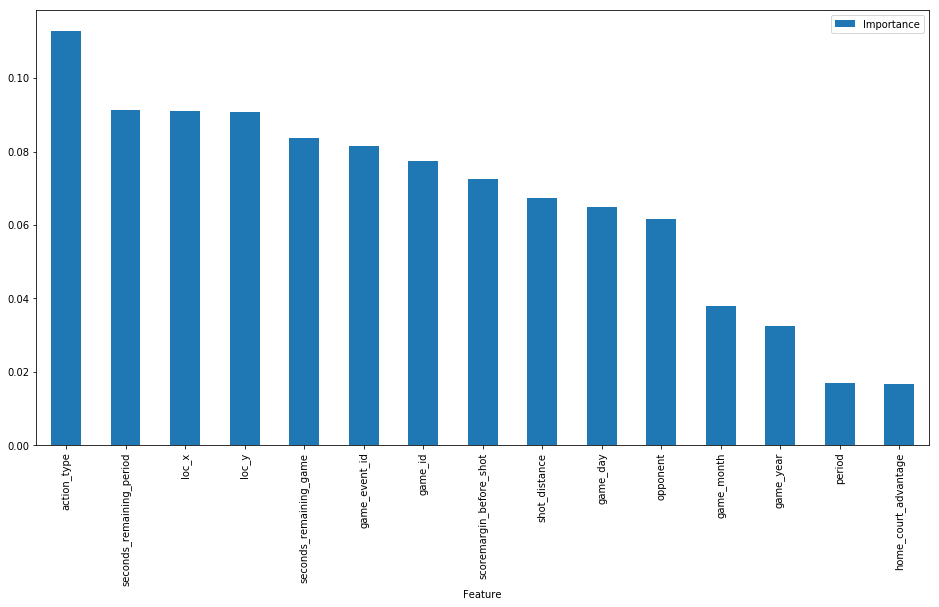

In [17]:
feature_importances = np.array(pipeline.named_steps['randomforestclassifier'].feature_importances_)
feature_names = np.array(pipeline.named_steps['dataframemapper'].transformed_names_)

importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importances_df.sort_values(by = 'Importance', ascending = False).plot.bar(x = 'Feature', y = 'Importance', figsize = (16, 8));

In [18]:
print(f'Test Validation Score: {pipeline.score(X_test, y_test):.3f}')

Test Validation Score: 0.623


In [19]:
!pip install pycm==2.4

     |████████████████████████████████| 51kB 3.4MB/s 
     |████████████████████████████████| 491kB 13.7MB/s 
     |████████████████████████████████| 215kB 48.3MB/s 
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 4.5.4 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1


In [0]:
from pycm import *

In [21]:
y_pred = pipeline.predict(X_test)
cm = ConfusionMatrix(actual_vector = np.array(y_test), predict_vector = np.array(y_pred))
cm.relabel(mapping = {0: 'Shot Not Made', 1: 'Shot Made'})
print(cm)

Predict             Shot Not Made       Shot Made           
Actual
Shot Made           459                 338                 

Shot Not Made       307                 605                 





Overall Statistics : 

95% CI                                                            (0.5996,0.64557)
ACC Macro                                                         0.62259
AUNP                                                              0.61964
AUNU                                                              0.61964
Bennett S                                                         0.24517
CBA                                                               0.60874
Chi-Squared                                                       98.46739
Chi-Squared DF                                                    1
Conditional Entropy                                               0.95035
Cramer V                                                          0.24004
Cross Entropy                        

In [22]:
cm2 = ConfusionMatrix(matrix = {"Negative": {"Negative": 85, "Positive": 58, }, 
                                "Positive": {"Negative": 8, "Positive": 36}})

cm2.print_matrix()

Predict        Negative       Positive       
Actual
Negative       85             58             

Positive       8              36             




In [23]:
cm2_accuracy = (85 + 36) / (85 + 36 + 8 + 58)
print(f'Accuracy: {cm2_accuracy:.3f}')

Accuracy: 0.647


In [24]:
cm2_precision = 36 / (36 + 58)
print(f'Precision: {cm2_precision:.3f}')

Precision: 0.383


In [25]:
cm2_recall = 36 / (36 + 8)
print(f'Recall: {cm2_recall:.3f}')

Recall: 0.818


In [26]:
cm2_F1 = 2 * ((cm2_precision * cm2_recall) / (cm2_precision + cm2_recall))
print(f'F1 Score: {cm2_F1:.3f}')

F1 Score: 0.522
